In [1]:
import tensorflow.keras as keras
import numpy as np
import matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph
import pygraphviz
import graphviz
import evolutionary_keras.optimizers
import networkx as nx
plt.rcParams['figure.figsize'] = [15, 5]
# from RWNN import RWNNmodel

Using TensorFlow backend.


In [7]:
from tensorflow.python.eager import backprop
import tensorflow as tf
from tensorflow.keras.constraints import Constraint
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.platform import tf_logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util import tf_inspect
from tensorflow.python.util.tf_export import keras_export

class removeSynapsesFF (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
        inputs =1
        msk=np.zeros([units,units])
        for i in range(units-outputs):
#             inds=range(i+1,i+pc+1)
            inds=np.random.randint(i+1, high=units, size=pc)
            for ind in inds:
                if ind != i and ind<units:
                    msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
#         V1=tf.keras.backend.sum(out,axis=1)
#         V2=tf.keras.backend.sum(w,axis=1)
#         Mult=V2/V1
#         Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
#         Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
#         out=tf.multiply(out, tf.expand_dims(Mult,1))
        out= tf.clip_by_value(out, clip_value_min=-3, clip_value_max=3)
        return out

class removeSynapsesRR (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
        inputs =1
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=np.random.randint(inputs, high=units, size=pc)
            for ind in inds:
                if ind != i:
                    msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
#         V1=tf.keras.backend.sum(out,axis=1)
#         V2=tf.keras.backend.sum(w,axis=1)
#         Mult=V2/V1
#         Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
#         Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
#         out=tf.multiply(out, tf.expand_dims(Mult,1))
        out= tf.clip_by_value(out, clip_value_min=-3, clip_value_max=3)
        return out


class removeSynapses (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
#         msk=1-np.tri(units,units) #upperdiagonal mask
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=np.random.randint(i+1, high=units, size=pc)
            for ind in inds:
                msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
        V1=tf.keras.backend.sum(out,axis=1)
        V2=tf.keras.backend.sum(w,axis=1)
        Mult=V2/V1
        Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
        Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
        out=tf.multiply(out, tf.expand_dims(Mult,1))
        out= tf.clip_by_value(out, clip_value_min=-3, clip_value_max=3)
        return out

# class removeSynapses (Constraint):
#     def __init__(self, units,pc=3):
#         outputs=1
# #         msk=1-np.tri(units,units) #upperdiagonal mask
#         msk=np.zeros([units,units])
#         for i in range(units-outputs):
#             inds=np.random.randint(i+1, high=units, size=pc)
#             for ind in inds:
#                 msk[i][ind]=1
#         self.mask=tf.Variable(msk,dtype=tf.float32)
#     def __call__(self, w):
#         out=tf.multiply(self.mask,w)
#         V=tf.keras.backend.sum(out,axis=2)
#         print (V)
# #         print (tf.keras.backend.sum(out,axis=2,keepdims=True))
#         print (out)
#         print (tf.multiply(out, tf.expand_dims(V,1)))
#         return out/abs(tf.keras.backend.sum(out))*abs(tf.keras.backend.sum(w))


# class removeSynapses (Constraint):
#     def __init__(self, units,pc=0.5,ff=True):
# #         msk=1-np.tri(units,units) #upperdiagonal mask
#         msk=rng.rand(units,units)
#         msk[msk > pc] = 0
#         msk[msk != 0] = 1
#         if ff:
#             msk *= 1 - np.tri(*msk.shape)
#         for i in range(len(msk)):
#             if sum(msk[i])==0:
#                 msk[i][-1]=1
#         if ff:
#             msk *= 1 - np.tri(*msk.shape)
#         self.mask=tf.Variable(msk,dtype=tf.float32)
#     def __call__(self, w):
#         return tf.multiply(self.mask,w)

class RWNN(Layer):
  def __init__(self,
               units,
               outunits,
               activation=None,
               use_bias=True,
               bias_initializer='ones',
               bias_constraint=None,
               kernel_initializer='glorot_uniform',
               iters=10,
               bias_regularizer=None,
               kernel_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape'] = (kwargs.pop('input_dim'),)

    super(RWNN, self).__init__(
        activity_regularizer=regularizers.get(activity_regularizer), **kwargs)

    self.units = int(units) if not isinstance(units, int) else units
    self.outunits=outunits
    self.iters=iters           
    self.activation = activations.get(activation)
    self.use_bias = use_bias
    self.bias_initializer = initializers.get(bias_initializer)
    self.bias_regularizer = regularizers.get(bias_regularizer)
    self.bias_constraint = constraints.get(bias_constraint)
    self.kernel_initializer = initializers.get(kernel_initializer)
    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.kernel_constraint = constraints.get(kernel_constraint)
    
    self.supports_masking = True
    self.input_spec = InputSpec(min_ndim=2)

  def build(self,input_shape):
    dtype = dtypes.as_dtype(self.dtype or K.floatx())
    self.inunits=input_shape[-1]
    self.kernel = self.add_weight(
        'kernel',
        shape=[self.units, self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    if self.use_bias:
        self.bias = self.add_weight(
            shape=[self.units,],
            initializer=self.bias_initializer,
            name='bias',
            regularizer=self.bias_regularizer,
            constraint=self.bias_constraint)
#     self.kernel=self.kernel_constraint.__call__(self.kernel)
    self.built = True

  def call(self, inputs,verbose=False):
#     self.kernel=tf.multiply(self.mask,self.kernel)
    if verbose:
        outhistory=[]
    inputs = math_ops.cast(inputs, self._compute_dtype)
    rank = len(inputs.shape)
    if inputs.shape[0] != None:
        z =tf.zeros((inputs.shape[0],self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    else:
        z =tf.zeros((1,self.units-self.inunits), dtype=tf.dtypes.float32, name=None)
    outputs = tf.concat([inputs, z], 1)
    for j in range(self.iters):
        outputs = gen_math_ops.mat_mul(outputs, self.kernel)
        if self.use_bias:
            outputs = outputs + self.bias
        if self.activation is not None:
            outputs=self.activation(outputs)
        aux= tf.gather(outputs, [self.inunits + i for i in range(self.units-self.inunits)], axis=1)
        outputs=tf.concat([inputs, aux], 1)
        if verbose:
            outhistory.append(np.array(outputs))
#             print (outputs)
#         print (tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1))
    if verbose:
        return np.array(outhistory)
    return tf.gather(outputs, [self.units-self.outunits + i for i in range(self.outunits)], axis=1)
    

  def compute_output_shape(self, input_shape):
    input_shape = tensor_shape.TensorShape(input_shape)
    input_shape = input_shape.with_rank_at_least(2)
    if tensor_shape.dimension_value(input_shape[-1]) is None:
      raise ValueError(
          'The innermost dimension of input_shape must be defined, but saw: %s'
          % input_shape)
    return input_shape[:-1].concatenate(self.outunits)
#     return self.outputs
  def plot_tree(self):
        G = nx.DiGraph(directed=True)
        idd=0
        #Nodes
        for i in range(self.inunits):
            G.add_node(idd,type='input',style='filled',fillcolor='red')
            idd+=1
        for i in range(self.units-self.outunits-self.inunits):
            if sum([self.kernel[i,idd] for i in range(self.units)]) != 0:
                G.add_node(idd,type='hidden')
            else:
                G.add_node(idd,type='bias',style='filled',fillcolor='magenta')
            idd+=1
        for i in range(self.outunits):
            G.add_node(idd,type='output',style='filled',fillcolor='blue')
            idd+=1
        #Connections
        for i in range(self.units):
            for j in range(self.units):
                weight=self.kernel[i,j]
                if weight != 0:
                    G.add_edge(i,j)
                    G[i][j]['penwidth']=abs(weight)
                    if weight >0:
                        G[i][j]['color']='green'
                    else:
                        G[i][j]['color']='red'

        #plot
        A = to_agraph(G)
        A.layout('dot')
        graphviz.Source(A).view()


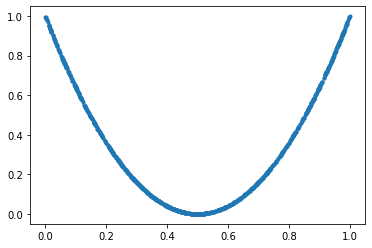

In [8]:
#1D
#simple 1d input -> 1d output training set (easy visualization)
seed=0
rng=np.random.RandomState(seed)
# x=2*rng.rand(1000,1)-1
# y=(x)**2

x=rng.rand(1000,1)
y=(2*(x-0.5))**2
plt.plot(x,y,'.',)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_8 (RWNN)                (1, 1)                    420       
_________________________________________________________________
dense_8 (Dense)              (1, 1)                    1         
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/800
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.1240
Epoch 2/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0911
Epoch 3/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0910
Epoch 4/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0914
Epoch 5/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0910
Epoch 6/800
1000/1000 [==============================] - 3s 3ms/sa

Epoch 88/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0905
Epoch 89/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0913
Epoch 90/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0911
Epoch 91/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0910
Epoch 92/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0908
Epoch 93/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0911
Epoch 94/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0911
Epoch 95/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0910
Epoch 96/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0910
Epoch 97/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0911
Epoch 98/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0910
Epoch 99/800
1000/1000 [===================

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0910
Epoch 182/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0909
Epoch 183/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0907
Epoch 184/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0907
Epoch 185/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0905
Epoch 186/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0908
Epoch 187/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0909
Epoch 188/800
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0908
Epoch 189/800
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0910
Epoch 190/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0907
Epoch 191/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0909
Epoch 192/800
1000/1000 [=====================

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0898
Epoch 275/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0900
Epoch 276/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0897
Epoch 277/800
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0893
Epoch 278/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0894
Epoch 279/800
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0897
Epoch 280/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0893
Epoch 281/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0897
Epoch 282/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0896
Epoch 283/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0888
Epoch 284/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0893
Epoch 285/800
1000/1000 [=====================

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0802
Epoch 368/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0801
Epoch 369/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0803
Epoch 370/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0798
Epoch 371/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0800
Epoch 372/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0799
Epoch 373/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0796
Epoch 374/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0798
Epoch 375/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0796
Epoch 376/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0798
Epoch 377/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0795
Epoch 378/800
1000/1000 [=====================

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0781
Epoch 461/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0780
Epoch 462/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0781
Epoch 463/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0781
Epoch 464/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0779
Epoch 465/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0779
Epoch 466/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0779
Epoch 467/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0777
Epoch 468/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0778
Epoch 469/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0773
Epoch 470/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0776
Epoch 471/800
1000/1000 [=====================

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0600
Epoch 554/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0601
Epoch 555/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0599
Epoch 556/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0602
Epoch 557/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0601
Epoch 558/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0598
Epoch 559/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0599
Epoch 560/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0597
Epoch 561/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0595
Epoch 562/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0599
Epoch 563/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0596
Epoch 564/800
1000/1000 [=====================

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0511
Epoch 647/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0505
Epoch 648/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0504
Epoch 649/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0502
Epoch 650/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0496
Epoch 651/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0495
Epoch 652/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0491
Epoch 653/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0489
Epoch 654/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0489
Epoch 655/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0484
Epoch 656/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0478
Epoch 657/800
1000/1000 [=====================

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0353
Epoch 740/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0350
Epoch 741/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0349
Epoch 742/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0348
Epoch 743/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0348
Epoch 744/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0346
Epoch 745/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0346
Epoch 746/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0342
Epoch 747/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0343
Epoch 748/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0341
Epoch 749/800
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0339
Epoch 750/800
1000/1000 [=====================

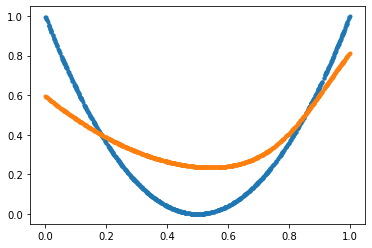

In [18]:
units=20
connections=5
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)
model = Sequential() 
model.add(
    RWNN(units,1, 
         activation='sigmoid',
         input_shape=(1,),
         kernel_initializer=init,
         iters=10 , 
         kernel_constraint=removeSynapsesFF(units,pc=connections)
        )) 
model.add(Dense(1, activation='linear',use_bias=False,kernel_initializer=init))
          
model.summary()

# opt = keras.optimizers.Adagrad(learning_rate=0.1)
opt = keras.optimizers.SGD(learning_rate=0.01)
# opt = evolutionary_keras.optimizers.NGA(population_size=10, sigma_original=15)

model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=1,
                    epochs=800,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

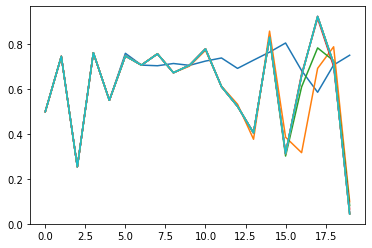

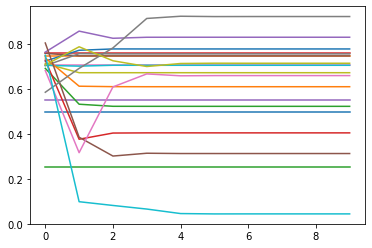

In [20]:
o=model.layers[0].call([[0.5]],verbose=True)
for oi in o:
    plt.plot(oi[0])
plt.figure()
for oi in o.transpose():
    plt.plot(oi[0])

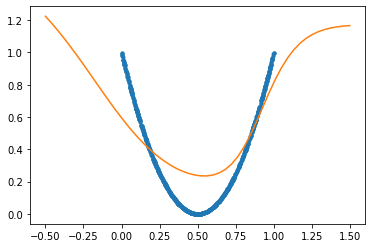

In [21]:
model.layers[0].plot_tree()
xx=np.linspace(-0.5, 1.5, num=50)
yy=model.predict(xx,batch_size=len(xx))
plt.plot(x,y,'.')
plt.plot(xx,yy,'-')

In [1115]:
class removeSynapses (Constraint):
    def __init__(self, units,pc=3):
        outputs=1
#         msk=1-np.tri(units,units) #upperdiagonal mask
        msk=np.zeros([units,units])
        for i in range(units-outputs):
            inds=np.random.randint(i+1, high=units, size=pc)
            for ind in inds:
                msk[i][ind]=1
        self.mask=tf.Variable(msk,dtype=tf.float32)
    def __call__(self, w):
        out=tf.multiply(self.mask,w)
        V1=tf.keras.backend.sum(out,axis=1)
        V2=tf.keras.backend.sum(w,axis=1)
        Mult=V2/V1
        Mult=tf.where(tf.math.is_nan(Mult), tf.zeros_like(Mult), Mult)
        Mult=tf.where(tf.math.is_inf(Mult), tf.zeros_like(Mult), Mult)
        
        print (V2)
        print (V1)
        print (Mult)
        out=tf.multiply(out, tf.expand_dims(Mult,1))
        print (out)
        print (tf.keras.backend.sum(out,axis=1))
        return out
k=removeSynapses(20)
k.__call__(model.layers[0].get_weights()[0])

tf.Tensor(
[-3.7636828   1.306529    1.4622831  -0.7100444  -2.1806304  -1.4464916
  1.172821   -0.5264728  -4.8839326  -1.1891308   5.139143    2.2901278
 -0.7609788  -3.534173   -0.33926508 -2.135209   -3.1173213  -0.5771899
 -1.2534275   0.        ], shape=(20,), dtype=float32)
tf.Tensor(
[-1.08256125e+00 -1.05140373e-01  2.98953354e-01  6.80997610e+00
 -9.42850471e-01  1.73501313e-01  2.32517576e+00 -1.16184115e-01
  1.84207201e+00  1.07502441e+02 -5.26824808e+00 -2.89510784e+01
  3.53482306e-01 -4.81262684e+00 -3.43846262e-01  1.65655003e+01
 -3.11732125e+00  7.72932386e+00 -1.25342751e+00  0.00000000e+00], shape=(20,), dtype=float32)
tf.Tensor(
[ 3.47664642e+00 -1.24265213e+01  4.89134216e+00 -1.04265325e-01
  2.31280613e+00 -8.33706474e+00  5.04401028e-01  4.53136635e+00
 -2.65132546e+00 -1.10614309e-02 -9.75493729e-01 -7.91033655e-02
 -2.15280604e+00  7.34354258e-01  9.86676633e-01 -1.28894940e-01
  1.00000000e+00 -7.46753439e-02  1.00000000e+00  0.00000000e+00], shape=(20,), d

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[-0.        , -0.0132158 , -0.        ,  0.        , -0.        ,
         0.        ,  0.        , -0.        ,  0.        , -3.7504668 ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.        , -0.        , -0.        ],
       [ 0.        , -0.        ,  0.34026325, -0.        , -0.        ,
        -0.831767  ,  0.        , -0.        ,  0.        , -0.        ,
         1.7980329 ,  0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -4.1141324 ,  0.        ,  5.5764155 ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ],
       [ 0.        , -0.        , -0.        ,  0.        , -0.        

In [123]:
# Print Weights 
for layer in model.layers:
    print(layer.get_weights()[0])
    print(np.max(layer.get_weights()[0]))
    print(np.min(layer.get_weights()[0]))

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_178 (RWNN)              (1, 1)                    10000     
Total params: 10,000
Trainable params: 10,000
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.1277
Epoch 2/80
1000/1000 [==============================] - 0s 382us/sample - loss: 1.1817
Epoch 3/80
1000/1000 [==============================] - 0s 383us/sample - loss: 1.1817
Epoch 4/80
1000/1000 [==============================] - 0s 443us/sample - loss: 1.1817
Epoch 5/80
1000/1000 [==============================] - 0s 398us/sample - loss: 1.1817
Epoch 6/80
1000/1000 [==============================] - 0s 456us/sample - loss: 1.1817
Epoch 7/80
1000/1000 [==============================] - 0s 408us/sample - loss: 1.1817
Epoch 8/80
100

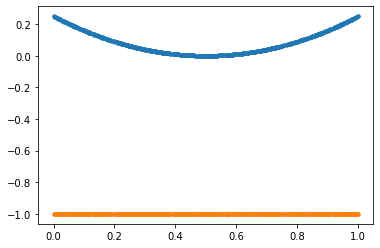

In [414]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)

model = Sequential() 
model.add(RWNN(100,1, activation='tanh',input_shape=(1,),kernel_initializer=init,iters=10, kernel_constraint=removeSynapses(100))) 
          
model.summary()

opt=keras.optimizers.Adagrad(learning_rate=1)
model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=10,
                    epochs=80,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

In [894]:
pc=0.5
msk=rng.rand(10,10)
msk[msk > pc] = 0
msk[msk != 0] = 1

msk *= 1 - np.tri(*msk.shape)
msk

array([[0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [360]:
msk=np.ones([10,10])
for i in range(10):
    for j in range(10):
        if i>=j:
            msk[i,j]=0
msk

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [368]:
1-np.tri(10,10)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [402]:
from tensorflow.python.ops import gen_math_ops
gen_math_ops.mat_mul([[1,10,100]], 1-np.tri(3,3))

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[ 0,  1, 11]], dtype=int32)>

In [406]:
np.dot([1,10,100], np.ones([3,3]))

array([111., 111., 111.])

In [788]:
def sig(x):
    return 1 / (1 + np.exp(-x))
#     return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) 

In [789]:
sig(1)

0.7310585786300049

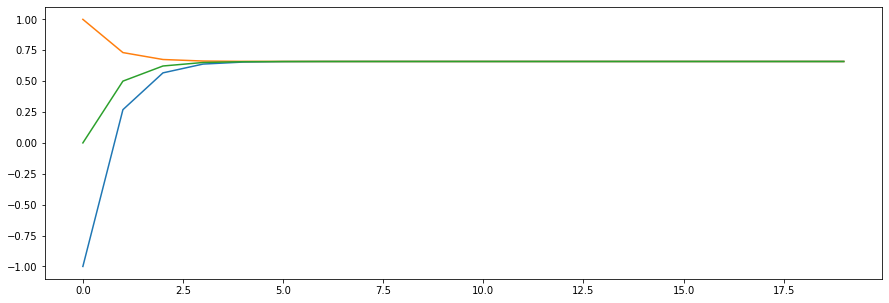

In [807]:
x = list(range(20))
y=[-1]
y2=[1]
y3=[0]
for i in x:
    y.append(sig(y[-1]))
    y2.append(sig(y2[-1]))
    y3.append(sig(y3[-1]))

plt.plot(x,y[:len(x)])
plt.plot(x,y2[:len(x)])
plt.plot(x,y3[:len(x)])

In [808]:
y

[-1,
 0.2689414213699951,
 0.5668330070205946,
 0.6380320873724359,
 0.6543084758952321,
 0.6579807100202137,
 0.6588066371986613,
 0.6589922651251212,
 0.6590339784724807,
 0.6590433517412365,
 0.6590454579604421,
 0.659045931237306,
 0.6590460375846879,
 0.6590460614814077,
 0.6590460668511046,
 0.6590460680576988,
 0.6590460683288258,
 0.6590460683897492,
 0.6590460684034389,
 0.6590460684065151,
 0.6590460684072064]

In [928]:
np.random.randint(2, high=5, size=20)

array([4, 4, 3, 4, 2, 2, 3, 4, 4, 4, 4, 2, 4, 4, 2, 4, 3, 3, 3, 4])

In [78]:
list(range(1,3+1))

[1, 2, 3]

In [174]:
a=RWNN(4,1, 
         activation='sigmoid',
         input_shape=(1,),
         kernel_initializer=init,
         iters=10 #, 
         #kernel_constraint=removeSynapses(units,pc=connections)
        )

In [175]:
a.build((1,))

In [176]:
a.kernel

<tf.Variable 'kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[-0.4351337 , -0.0031662 ,  0.43091702, -0.9595959 ],
       [-0.8428037 ,  0.25311875,  0.50999665, -0.6535883 ],
       [-0.7425747 , -0.89465904,  0.8850584 , -0.5390961 ],
       [-0.04491687, -0.5068898 ,  0.449152  ,  0.5381317 ]],
      dtype=float32)>

In [177]:
a.bias

<tf.Variable 'bias:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

In [178]:
a.kernel+a.bias

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.5648663 , 0.9968338 , 1.430917  , 0.04040408],
       [0.15719628, 1.2531188 , 1.5099967 , 0.3464117 ],
       [0.2574253 , 0.10534096, 1.8850584 , 0.46090388],
       [0.95508313, 0.49311018, 1.449152  , 1.5381317 ]], dtype=float32)>

In [179]:
out=a.call([[2]])[0]

In [180]:
out

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.        , 0.32505566, 0.86077857, 0.0719601 ], dtype=float32)>

In [181]:
out+a.bias

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([3.       , 1.3250556, 1.8607786, 1.0719601], dtype=float32)>

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rwnn_69 (RWNN)               (1, 10)                   2550      
_________________________________________________________________
rwnn_70 (RWNN)               (1, 1)                    420       
_________________________________________________________________
dense_54 (Dense)             (1, 1)                    1         
Total params: 2,971
Trainable params: 2,971
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples
Epoch 1/80
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.2076
Epoch 2/80
1000/1000 [==============================] - 1s 857us/sample - loss: 0.2056
Epoch 3/80
1000/1000 [==============================] - 1s 803us/sample - loss: 0.2053
Epoch 4/80
1000/1000 [==============================] - 1s 766us/sample - loss: 0.2052
Epoch 5/80
10

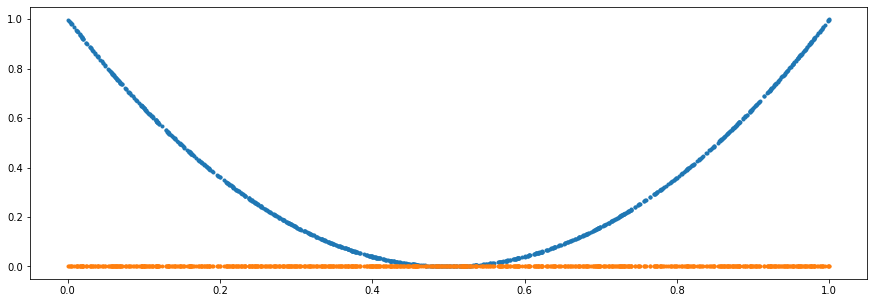

In [206]:
init=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=42)
model = Sequential() 
model.add(
    RWNN(50,10, 
         activation='sigmoid',
         input_shape=(1,),
         kernel_initializer=init,
         iters=10 , 
         kernel_constraint=removeSynapsesRR(50,pc=10)
        )) 
model.add(
    RWNN(20,1, 
         activation='sigmoid',
         input_shape=(1,),
         kernel_initializer=init,
         iters=10 , 
         kernel_constraint=removeSynapsesFF(20,pc=10)
        )) 
model.add(Dense(1, activation='linear',use_bias=False,kernel_initializer=init))
          
model.summary()

# opt = keras.optimizers.Adagrad(learning_rate=0.1)
opt = keras.optimizers.SGD(learning_rate=0.1)
# opt = evolutionary_keras.optimizers.NGA(population_size=10, sigma_original=15)

model.compile(loss='mean_squared_error',
              optimizer=opt)


history = model.fit(x, y,
                    batch_size=8,
                    epochs=80,
                    verbose=1)
yy=model.predict(x,batch_size=len(x))
plt.plot(x,y,'.')
plt.plot(x,yy,'.')

In [207]:
model.layers[0].plot_tree()
model.layers[1].plot_tree()
